In [29]:
using Pkg
Pkg.activate("../../../Project.toml")

include("../../../LogLoss/RealRealHighDimension.jl")
include("../../../Interpolation/imputation.jl");
using JLD2
using DataFrames
using StatProfilerHTML
using BenchmarkTools

  Activating project at `~/Documents/QML Project/QuantumInspiredML`


# Import the data (you'll only have the first example locally)

In [72]:

svpath_test = "../../../Data/ecg200/mps_saves/legendreNN2_ns_d8_chi35_TSGO.jld2"
svpath_slb = "../../../Data/ecg200/mps_saves/sahand_legendre_ns_d20_chi100_range.jld2" #legendre_no_norm_ns_d16_chi60.jld2" #legendreNN2_ns_d8_chi35.jld2"
svpath_sl = "../../../Data/ecg200/mps_saves/sahand_legendre_ns_d20_chi100.jld2"
svpath_leg = "../../../Data/ecg200/mps_saves/legendre_no_norm10_ns_d20_chi100.jld2" #legendre_no_norm_ns_d16_chi60.jld2" #legendreNN2_ns_d8_chi35.jld2"

dloc =  "../../../Data/ecg200/datasets/ecg200.jld2"



f = jldopen(dloc, "r")
    X_train = read(f, "X_train")
    y_train = read(f, "y_train")
    X_test = read(f, "X_test")
    y_test = read(f, "y_test")
close(f)



###################################
f = jldopen(svpath_test, "r")
    mps_test = read(f, "mps")
    opts_test = read(f, "opts")
close(f)

opts_test, _... = safe_options(opts_test, nothing, nothing)

fc_test = load_forecasting_info_variables(mps_test, X_train, y_train, X_test, y_test, opts_test);

###################################3

f = jldopen(svpath_sl, "r")
    mps_sl = read(f, "mps")
    opts_sl = read(f, "opts")
close(f)

opts_sl, _... = safe_options(opts_sl, nothing, nothing)

fc_sl = load_forecasting_info_variables(mps_sl, X_train, y_train, X_test, y_test, opts_sl);


#########################################
f = jldopen(svpath_slb, "r")
    mps_slb = read(f, "mps")
    opts_slb = read(f, "opts")
close(f)

opts_slb, _... = safe_options(opts_slb, nothing, nothing)

fc_slb = load_forecasting_info_variables(mps_slb, X_train, y_train, X_test, y_test, opts_slb);

#########################################
f = jldopen(svpath_leg, "r")
    mps_leg = read(f, "mps")
    opts_leg = read(f, "opts")
close(f)

opts_leg, _... = safe_options(opts_leg, nothing, nothing)

fc_leg = load_forecasting_info_variables(mps_leg, X_train, y_train, X_test, y_test, opts_leg);



++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
                         Summary:

 - Dataset has 100 training samples and 100 testing samples.
 - 2 class(es) was detected. Slicing MPS into individual states...
 - Time independent encoding - Legendre_No_Norm - detected.
 - d = 8, chi_max = 35

 Created 2 forecastable struct(s) containing class-wise mps and test samples.
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
                         Summary:

 - Dataset has 100 training samples and 100 testing samples.
 - 2 class(es) was detected. Slicing MPS into individual states...
 - Time independent encoding - Sahand-Legendre Time Independent - detected.
 - d = 20, chi_max = 100
Re-encoding the training data to get the encoding arguments...

 Created 2 forecastable struct(s) containing class-wise mps and test samples.
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
                         Summary:

 - Dataset has 100 training samples and 100 testing

In [77]:
opts_test

Options
  verbosity: Int64 1
  nsweeps: Int64 20
  chi_max: Int64 35
  cutoff: Float64 1.0e-10
  update_iters: Int64 1
  dtype: Float64 <: AbstractFloat
  loss_grad: Loss_Grad_KLD() (function of type Loss_Grad_KLD)
  bbopt: BBOpt
  track_cost: Bool false
  eta: Float64 0.0025
  rescale: Tuple{Bool, Bool}
  d: Int64 8
  aux_basis_dim: Int64 2
  encoding: Basis
  train_classes_separately: Bool false
  encode_classes_separately: Bool false
  return_encoding_meta_info: Bool false
  minmax: Bool true
  exit_early: Bool false
  sigmoid_transform: Bool false
  log_level: Int64 0
  data_bounds: Tuple{Float64, Float64}


# Running a single Imputation

In [78]:
dx=1E-4
mode_range=(-1,1)
xvals=collect(range(mode_range...; step=dx))
mode_index=Index(opts_test.d)
xvals_enc= [get_state(x, opts_test, fc_test[1].enc_args) for x in xvals]
xvals_enc_it=[ITensor(s, mode_index) for s in xvals_enc];

  2.093853 seconds (17.03 M allocations: 1.164 GiB, 14.49% gc time)
╭────────┬──────────╮
│ Metric │    Value │
├────────┼──────────┤
│    MAE │ 0.566727 │
│ NN_MAE │ 0.562345 │
╰────────┴──────────╯


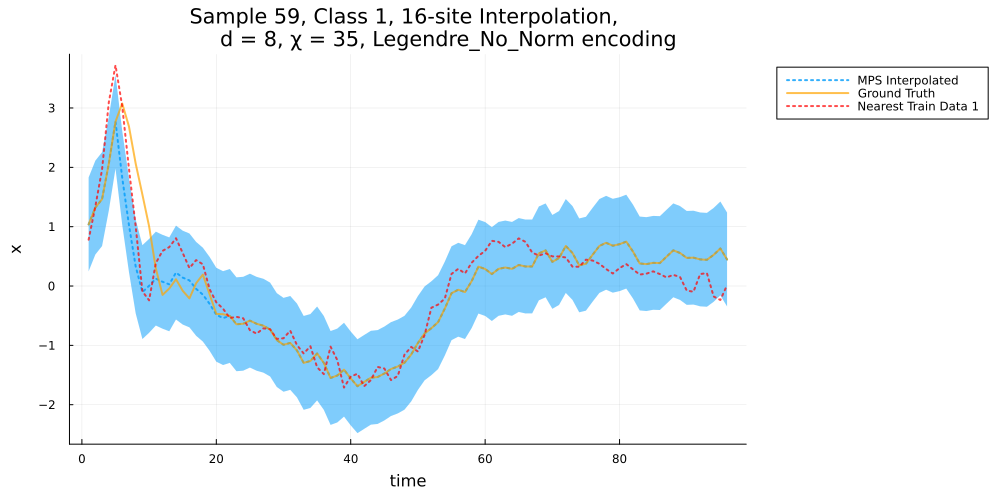

In [80]:

max_jump=0.5
class = 1
interp_sites = collect(6:21)
instance_idx = 59 # 4
invert_transform=true
@time begin 
stats, p1_ns = any_impute_single_timeseries(fc_test, class, instance_idx, interp_sites, :directMedian; invert_transform=invert_transform, NN_baseline=true, X_train=X_train, y_train=y_train, n_baselines=1, plot_fits=true, dx=dx, mode_range=mode_range, xvals=xvals, mode_index=mode_index, xvals_enc=xvals_enc, xvals_enc_it=xvals_enc_it);
end

pretty_table(stats; header=["Metric", "Value"], header_crayon= crayon"yellow bold", tf = tf_unicode_rounded);
plot(p1_ns...)


1 rescaling operations were performed!
118.858280 seconds (93.50 M allocations: 134.723 GiB, 6.55% gc time, 5.83% compilation time)


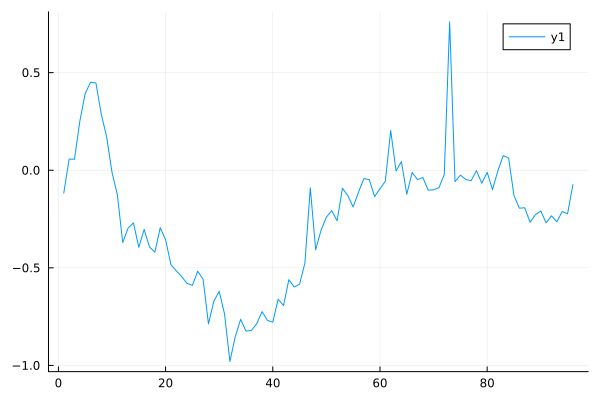

In [81]:
include("../../../Interpolation/imputation.jl");

max_jump=0.5
class = 0
interp_sites = collect(1:80)
instance_idx = 8 # 4
invert_transform=false
@time begin 
ts = any_impute_ITS(fc_test, class, instance_idx, interp_sites; invert_transform=invert_transform, X_train=X_train, y_train=y_train, plot_fits=true);
end

plot(ts)


# Running A comparison

In [20]:
mode_range=(-1,1)
xvals=collect(range(mode_range...; step=1E-4))
mode_index = Index(opts_sl.d)

xvals_enc_slb= [get_state(x, opts_slb, fc_slb[1].enc_args) for x in xvals]
xvals_enc_it_slb=[ITensor(s, mode_index) for s in xvals_enc_slb];

xvals_enc_sl= [get_state(x, opts_sl, fc_sl[1].enc_args) for x in xvals]
xvals_enc_it_sl=[ITensor(s, mode_index) for s in xvals_enc_sl];

xvals_enc_leg= [get_state(x, opts_leg, fc_leg[1].enc_args) for x in xvals]
xvals_enc_it_leg=[ITensor(s, mode_index) for s in xvals_enc_leg];

n1s = sum(y_test)
n0s = length(y_test) - n1s

samples = [1:n0s; 1:n1s]
interp_sites = collect(3:21)

classes = [zeros(Int,n0s); ones(Int,n1s)]
max_jump=1
slb_ps = []
slb_stats = []

sl_ps = []
sl_stats = []

leg_ps = []
leg_stats = []

for (i,s) in enumerate(samples)
    
    println("$i/$(length(samples))")
    class = classes[i]
    instance_idx = s
    slb_s_single_timeseries(fc_slb, class, instance_idx, interp_sites, :directMedian; NN_baseline=true, X_train=X_train, y_train=y_train, plot_fits=true, mode_range=mode_range, xvals=xvals, mode_index=mode_index, xvals_enc=xvals_enc_slb, xvals_enc_it=xvals_enc_it_slb);
    push!(slb_ps, slb_p1...)
    push!(slb_stats, slb_stat)

    leg_stat, leg_p1 = any_impute_single_timeseries(fc_leg, class, instance_idx, interp_sites, :directMedian; NN_baseline=true, X_train=X_train, y_train=y_train, plot_fits=true, mode_range=mode_range, xvals=xvals, mode_index=mode_index, xvals_enc=xvals_enc_leg, xvals_enc_it=xvals_enc_it_leg);
    push!(leg_ps, leg_p1...)
    push!(leg_stats, leg_stat)

    sl_stat, sl_p1 = any_impute_single_timeseries(fc_sl, class, instance_idx, interp_sites, :directMedian; NN_baseline=true, X_train=X_train, y_train=y_train, plot_fits=true, mode_range=mode_range, xvals=xvals, mode_index=mode_index, xvals_enc=xvals_enc_sl, xvals_enc_it=xvals_enc_it_sl);
    push!(sl_ps, sl_p1...)
    push!(sl_stats, sl_stat)


end

94/100
1 rescaling operations were performed!
1 rescaling operations were performed!
1 rescaling operations were performed!
1 rescaling operations were performed!
95/100
96/100
97/100
98/100
99/100
100/100


In [21]:
svpath = "Median_d20chi100_sites3:21_leg_sl_slb.jld2"
# f = jldopen(svpath, "w")
#     write(f, "slb_stats", slb_stats)
#     write(f, "sl_stats", sl_stats)
#     write(f, "leg_stats", leg_stats)

# close(f)
# f = jldopen(svpath, "r")
#     sl_stats = f["sl_stats"]
#     slb_stats = f["slb_stats"]
#     leg_stats = f["leg_stats"]
# close(f)

In [31]:
stats_slb = vcat(DataFrame.(slb_stats)...)
stats_sl = vcat(DataFrame.(sl_stats)...)
stats_leg = vcat(DataFrame.(leg_stats)...)

println("Legendre")
@show describe(stats_leg) 

println("S-L")
@show describe(stats_sl)

println("SL-Bounded")
@show describe(stats_slb)





@show zip(sortperm(stats_sl[!,1]), stats_sl[!,1])  |> collect |> reverse

Legendre
describe(stats_leg) = 2×7 DataFrame
 Row │ variable  mean      min       median    max      nmissing  eltype
     │ Symbol    Float64   Float64   Float64   Float64  Int64     DataType
─────┼─────────────────────────────────────────────────────────────────────
   1 │ MAE       0.53366   0.110944  0.38475   2.41154         0  Float64
   2 │ NN_MAE    0.393455  0.130001  0.330921  1.47692         0  Float64
S-L
describe(stats_sl) = 2×7 DataFrame
 Row │ variable  mean      min       median    max      nmissing  eltype
     │ Symbol    Float64   Float64   Float64   Float64  Int64     DataType
─────┼─────────────────────────────────────────────────────────────────────
   1 │ MAE       0.526659  0.109338  0.370299  2.41204         0  Float64
   2 │ NN_MAE    0.393455  0.130001  0.330921  1.47692         0  Float64
SL-Bounded
describe(stats_slb) = 2×7 DataFrame
 Row │ variable  mean      min       median    max      nmissing  eltype
     │ Symbol    Float64   Float64   Float64   Float

93-element Vector{Tuple{Int64, Float64}}:
 (13, 0.3146189430289472)
 (16, 0.3861437949460526)
 (8, 0.43090936720000006)
 (24, 0.8890669391065793)
 (34, 0.19351648610394717)
 (4, 0.598894048392105)
 (19, 0.24952747491052604)
 (71, 0.35852448191315806)
 (53, 0.39272170318947375)
 (12, 0.2337565264421054)
 ⋮
 (27, 0.21206880078947413)
 (44, 2.147934170797369)
 (18, 0.38642825556184235)
 (40, 0.7339798115644737)
 (67, 0.6696097487447364)
 (55, 1.5012517367947371)
 (69, 0.4947027118013161)
 (14, 0.2800404587552629)
 (57, 0.5379084110605262)

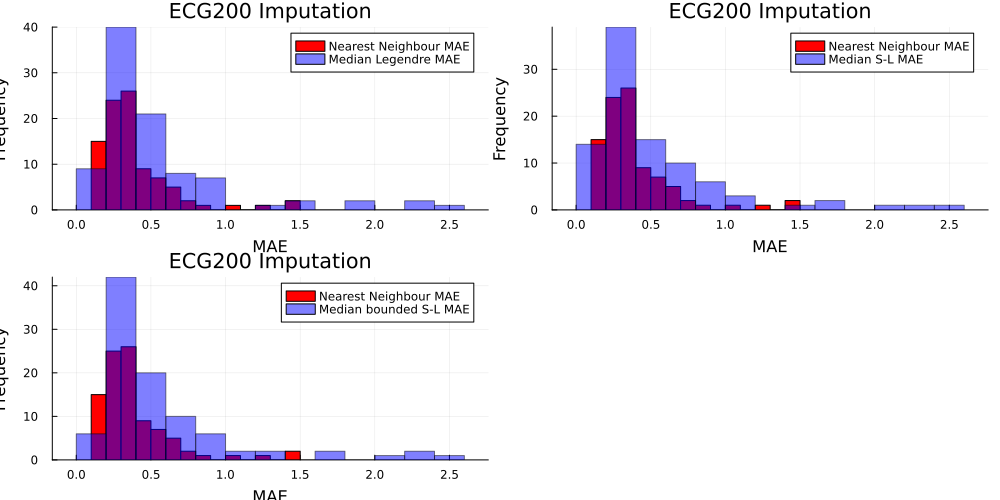

In [28]:
nbins=20
histogram(stats_leg[!, :NN_MAE], label="Nearest Neighbour MAE", colour=:red, bins=nbins)
h1 = histogram!(stats_leg[!, :MAE], label="Median Legendre MAE", colour=:blue, alpha=0.5, bins=nbins)
ylabel!("Frequency")
xlabel!("MAE")

histogram(stats_sl[!, :NN_MAE], label="Nearest Neighbour MAE", colour=:red, bins=nbins)
h2 = histogram!(stats_sl[!, :MAE], label="Median S-L MAE", colour=:blue, alpha=0.5, bins=nbins)
ylabel!("Frequency")
xlabel!("MAE")

histogram(stats_slb[!, :NN_MAE], label="Nearest Neighbour MAE", colour=:red, bins=nbins)
h3 = histogram!(stats_slb[!, :MAE], label="Median bounded S-L MAE", colour=:blue, alpha=0.5, bins=nbins)
ylabel!("Frequency")
xlabel!("MAE")


p = plot([h1, h2, h3]..., size=(1000,500), title="ECG200 Imputation")
# savefig(p, "figs/hists.svg")

100-element Vector{Int64}:
  8
 24
 13
 34
  4
 16
  6
 53
 58
 25
  ⋮
  9
 14
 55
 62
 50
 69
 40
 56
 57

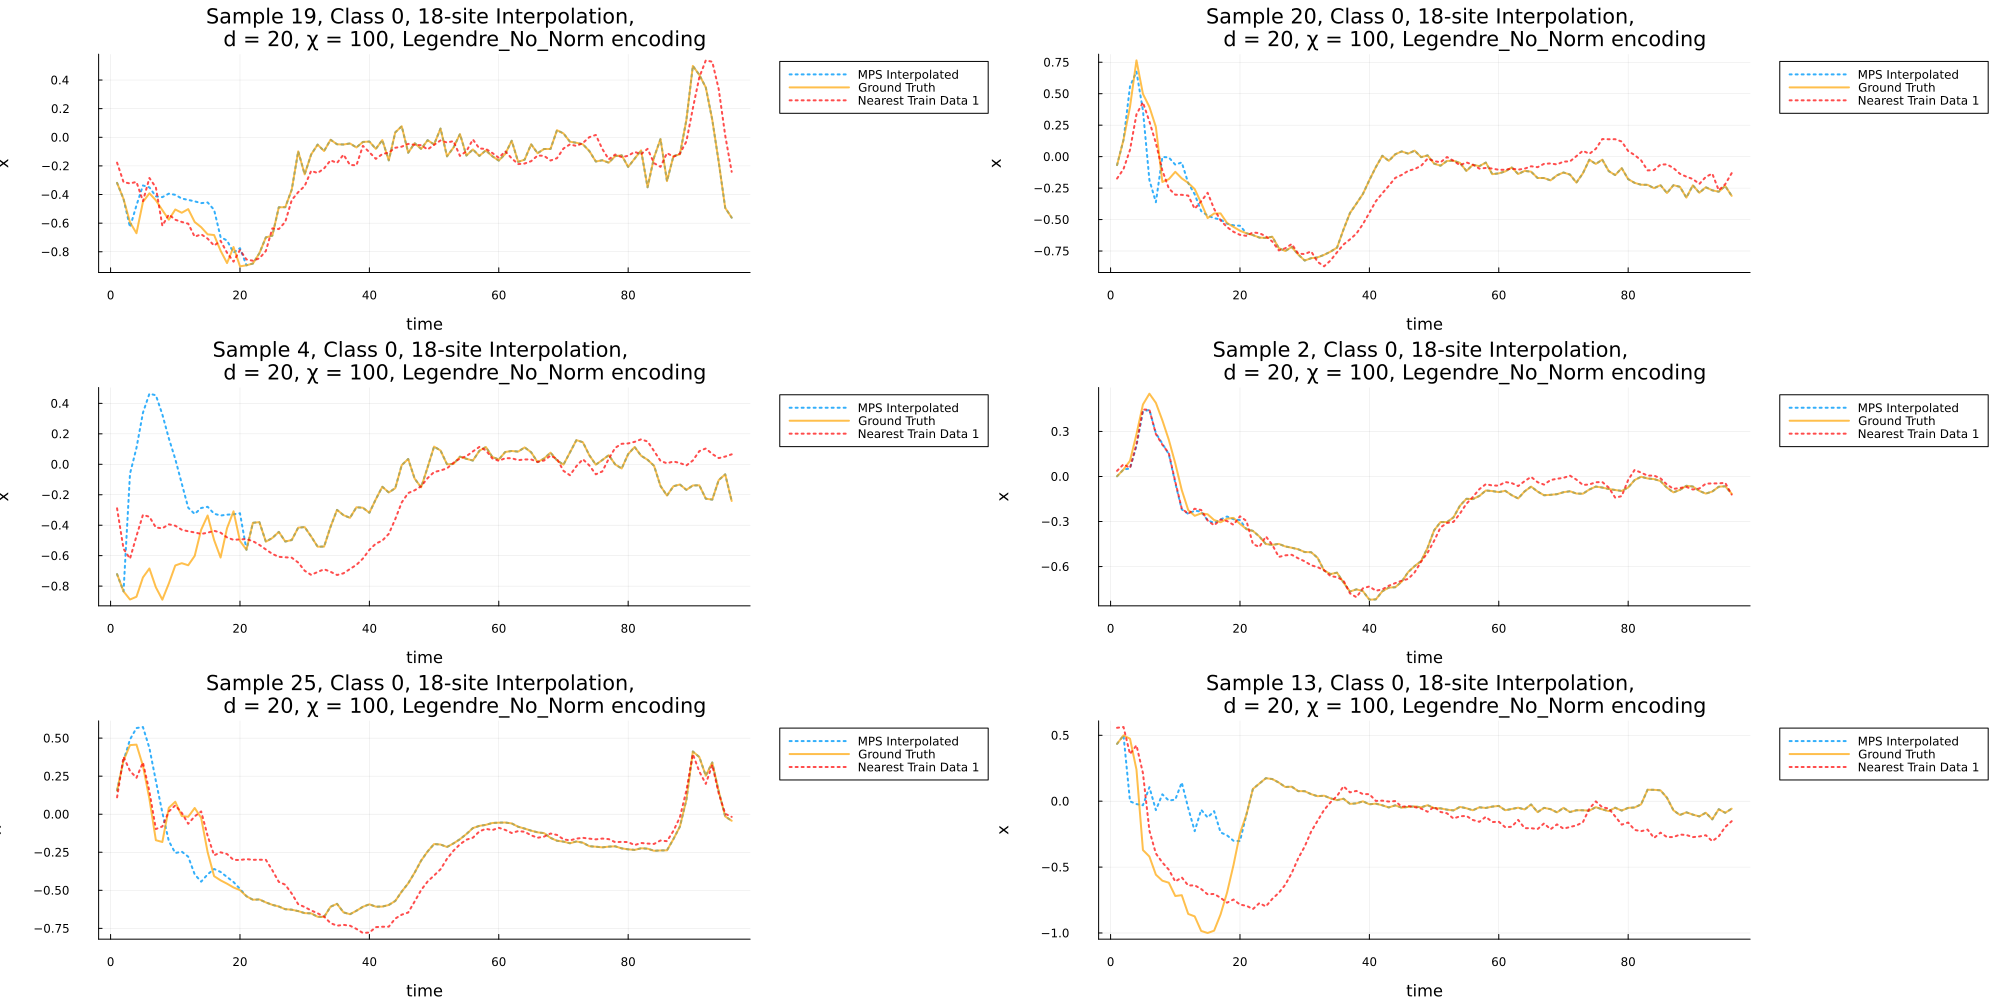

In [98]:
p1 = plot(ps[1:6]..., size=(2000,1000), layout=(3,2))
# savefig(p1, "figs/c0ecg.svg")

p2 = plot(ps[7:12]..., size=(2000,1000), layout=(3,2))
# savefig(p2, "figs/c1ecg.svg")
p1


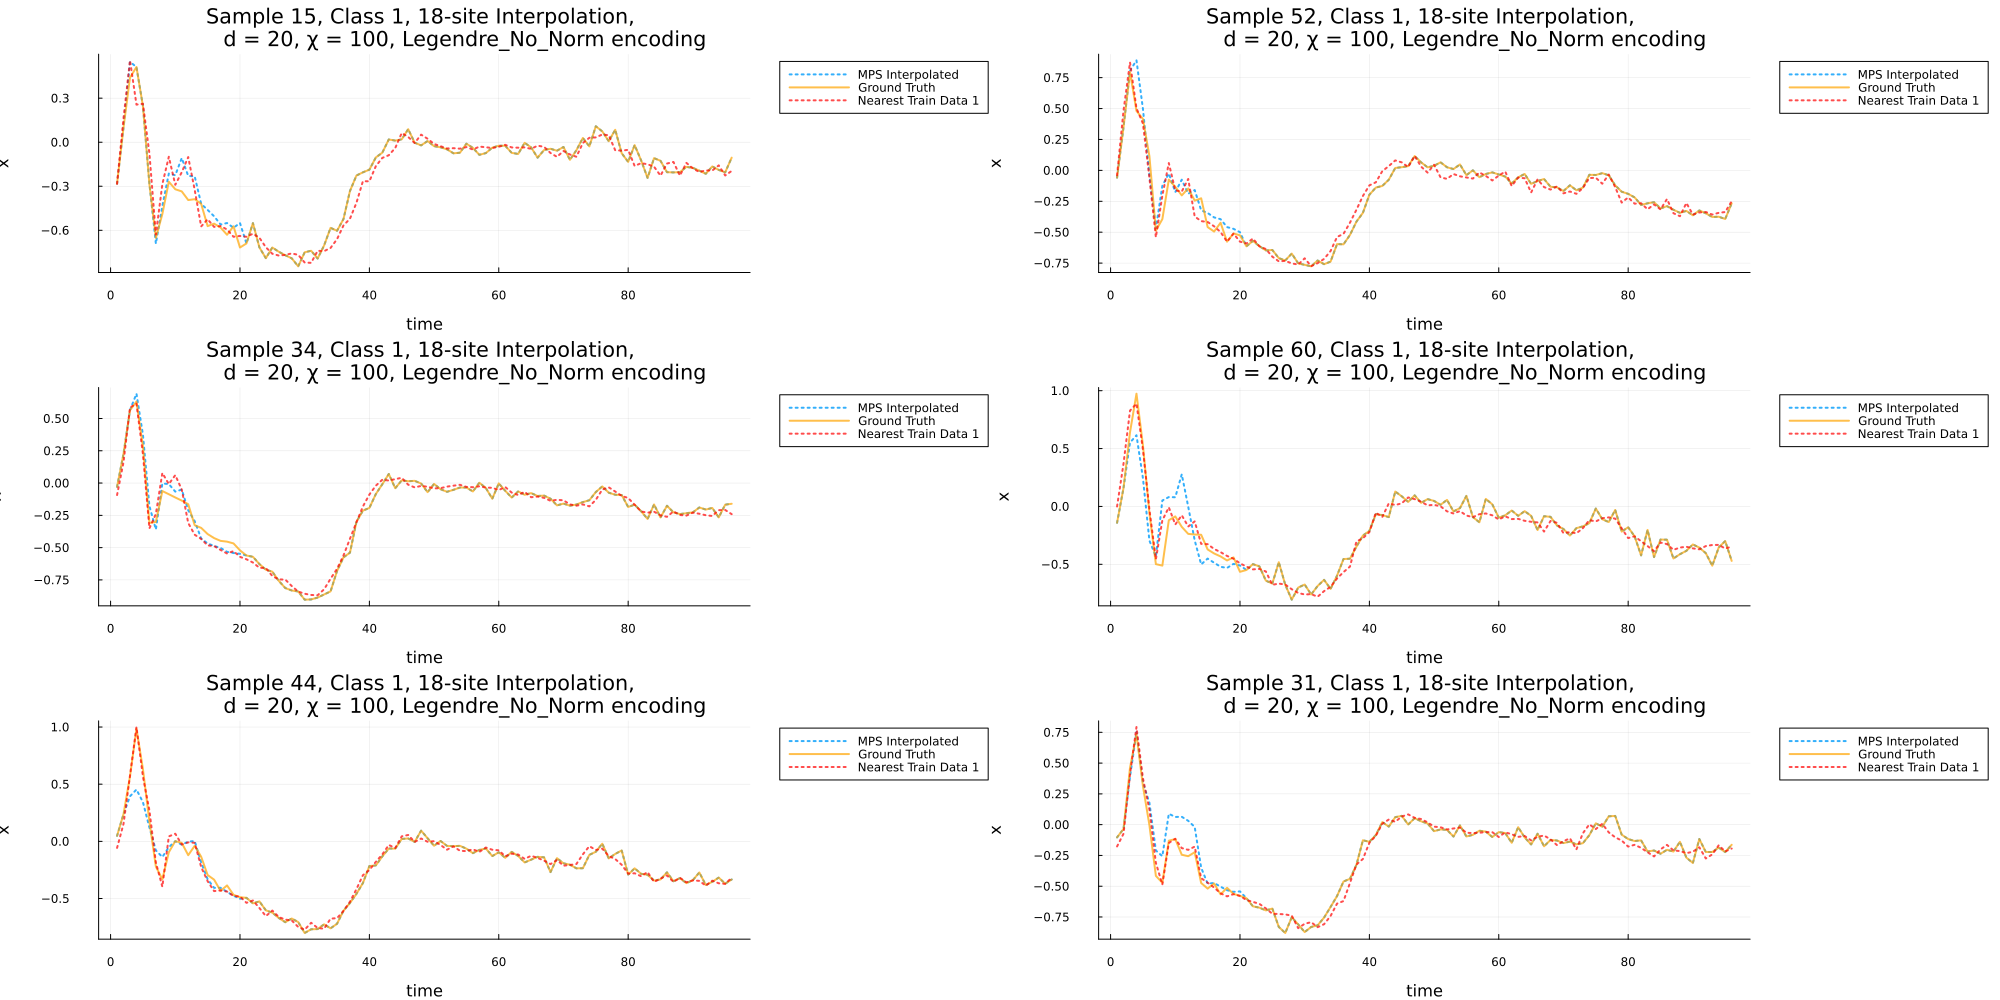

In [99]:
p2